定义rvm的类，回归和分类都有

In [2]:
"""Relevance Vector Machine classes for regression and classification."""
import numpy as np
 
from scipy.optimize import minimize
from scipy.special import expit
 
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.metrics.pairwise import (
    linear_kernel,
    rbf_kernel,
    polynomial_kernel
)
from sklearn.multiclass import OneVsOneClassifier
from sklearn.utils.validation import check_X_y
 
 
class BaseRVM(BaseEstimator):
 
    """Base Relevance Vector Machine class.
    Implementation of Mike Tipping's Relevance Vector Machine using the
    scikit-learn API. Add a posterior over weights method and a predict
    in subclass to use for classification or regression.
    """
 
    def __init__(
        self,
        kernel='rbf',
        degree=3,
        coef1=None,
        coef0=0.0,
        n_iter=3000,
        tol=1e-3,
        alpha=1e-6,
        threshold_alpha=1e9,
        beta=1.e-6,
        beta_fixed=False,
        bias_used=True,
        verbose=False
    ):
        """Copy params to object properties, no validation."""
        self.kernel = kernel
        self.degree = degree
        self.coef1 = coef1
        self.coef0 = coef0
        self.n_iter = n_iter
        self.tol = tol
        self.alpha = alpha
        self.threshold_alpha = threshold_alpha
        self.beta = beta
        self.beta_fixed = beta_fixed
        self.bias_used = bias_used
        self.verbose = verbose
 
    def get_params(self, deep=True):
        """Return parameters as a dictionary."""
        params = {
            'kernel': self.kernel,
            'degree': self.degree,
            'coef1': self.coef1,
            'coef0': self.coef0,
            'n_iter': self.n_iter,
            'tol': self.tol,
            'alpha': self.alpha,
            'threshold_alpha': self.threshold_alpha,
            'beta': self.beta,
            'beta_fixed': self.beta_fixed,
            'bias_used': self.bias_used,
            'verbose': self.verbose
        }
        return params
 
    def set_params(self, **parameters):
        """Set parameters using kwargs."""
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
 
    def _apply_kernel(self, x, y):
        """Apply the selected kernel function to the data."""
        if self.kernel == 'linear':
            phi = linear_kernel(x, y)
        elif self.kernel == 'rbf':
            phi = rbf_kernel(x, y, self.coef1)
        elif self.kernel == 'poly':
            phi = polynomial_kernel(x, y, self.degree, self.coef1, self.coef0)
        elif callable(self.kernel):
            phi = self.kernel(x, y)
            if len(phi.shape) != 2:
                raise ValueError(
                    "Custom kernel function did not return 2D matrix"
                )
            if phi.shape[0] != x.shape[0]:
                raise ValueError(
                    "Custom kernel function did not return matrix with rows"
                    " equal to number of data points."""
                )
        else:
            raise ValueError("Kernel selection is invalid.")
 
        if self.bias_used:
            phi = np.append(phi, np.ones((phi.shape[0], 1)), axis=1)
 
        return phi
 
    def _prune(self):
        """Remove basis functions based on alpha values."""
        keep_alpha = self.alpha_ < self.threshold_alpha
 
        if not np.any(keep_alpha):
            keep_alpha[0] = True
            if self.bias_used:
                keep_alpha[-1] = True
 
        if self.bias_used:
            if not keep_alpha[-1]:
                self.bias_used = False
            self.relevance_ = self.relevance_[keep_alpha[:-1]]
        else:
            self.relevance_ = self.relevance_[keep_alpha]
 
        self.alpha_ = self.alpha_[keep_alpha]
        self.alpha_old = self.alpha_old[keep_alpha]
        self.gamma = self.gamma[keep_alpha]
        self.phi = self.phi[:, keep_alpha]
        self.sigma_ = self.sigma_[np.ix_(keep_alpha, keep_alpha)]
        self.m_ = self.m_[keep_alpha]
 
    def fit(self, X, y):
        """Fit the RVR to the training data."""
        X, y = check_X_y(X, y)
 
        n_samples, n_features = X.shape
 
        self.phi = self._apply_kernel(X, X)
 
        n_basis_functions = self.phi.shape[1]
 
        self.relevance_ = X
        self.y = y
 
        self.alpha_ = self.alpha * np.ones(n_basis_functions)
        self.beta_ = self.beta
 
        self.m_ = np.zeros(n_basis_functions)
 
        self.alpha_old = self.alpha_
 
        for i in range(self.n_iter):
            self._posterior()
 
            self.gamma = 1 - self.alpha_*np.diag(self.sigma_)
            self.alpha_ = self.gamma/(self.m_ ** 2)
 
            if not self.beta_fixed:
                self.beta_ = (n_samples - np.sum(self.gamma))/(
                    np.sum((y - np.dot(self.phi, self.m_)) ** 2))
 
            self._prune()
 
            if self.verbose:
                print("Iteration: {}".format(i))
                print("Alpha: {}".format(self.alpha_))
                print("Beta: {}".format(self.beta_))
                print("Gamma: {}".format(self.gamma))
                print("m: {}".format(self.m_))
                print("Relevance Vectors: {}".format(self.relevance_.shape[0]))
                print()
 
            delta = np.amax(np.absolute(self.alpha_ - self.alpha_old))
 
            if delta < self.tol and i > 1:
                break
 
            self.alpha_old = self.alpha_
 
        if self.bias_used:
            self.bias = self.m_[-1]
        else:
            self.bias = None
 
        return self
 
 
class RVR(BaseRVM, RegressorMixin):
 
    """Relevance Vector Machine Regression.
    Implementation of Mike Tipping's Relevance Vector Machine for regression
    using the scikit-learn API.
    """
 
    def _posterior(self):
        """Compute the posterior distriubtion over weights."""
        i_s = np.diag(self.alpha_) + self.beta_ * np.dot(self.phi.T, self.phi)
        self.sigma_ = np.linalg.inv(i_s)
        self.m_ = self.beta_ * np.dot(self.sigma_, np.dot(self.phi.T, self.y))
 
    def predict(self, X, eval_MSE=False):
        """Evaluate the RVR model at x."""
        phi = self._apply_kernel(X, self.relevance_)
 
        y = np.dot(phi, self.m_)
 
        if eval_MSE:
            MSE = (1/self.beta_) + np.dot(phi, np.dot(self.sigma_, phi.T))
            return y, MSE[:, 0]
        else:
            return y
 
 
class RVC(BaseRVM, ClassifierMixin):
 
    """Relevance Vector Machine Classification.
    Implementation of Mike Tipping's Relevance Vector Machine for
    classification using the scikit-learn API.
    """
 
    def __init__(self, n_iter_posterior=50, **kwargs):
        """Copy params to object properties, no validation."""
        self.n_iter_posterior = n_iter_posterior
        super(RVC, self).__init__(**kwargs)
 
    def get_params(self, deep=True):
        """Return parameters as a dictionary."""
        params = super(RVC, self).get_params(deep=deep)
        params['n_iter_posterior'] = self.n_iter_posterior
        return params
 
    def _classify(self, m, phi):
        return expit(np.dot(phi, m))
 
    def _log_posterior(self, m, alpha, phi, t):
 
        y = self._classify(m, phi)
 
        log_p = -1 * (np.sum(np.log(y[t == 1]), 0) +
                      np.sum(np.log(1-y[t == 0]), 0))
        log_p = log_p + 0.5*np.dot(m.T, np.dot(np.diag(alpha), m))
 
        jacobian = np.dot(np.diag(alpha), m) - np.dot(phi.T, (t-y))
 
        return log_p, jacobian
 
    def _hessian(self, m, alpha, phi, t):
        y = self._classify(m, phi)
        B = np.diag(y*(1-y))
        return np.diag(alpha) + np.dot(phi.T, np.dot(B, phi))
 
    def _posterior(self):
        result = minimize(
            fun=self._log_posterior,
            hess=self._hessian,
            x0=self.m_,
            args=(self.alpha_, self.phi, self.t),
            method='Newton-CG',
            jac=True,
            options={
                'maxiter': self.n_iter_posterior
            }
        )
 
        self.m_ = result.x
        self.sigma_ = np.linalg.inv(
            self._hessian(self.m_, self.alpha_, self.phi, self.t)
        )
 
    def fit(self, X, y):
        """Check target values and fit model."""
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
 
        if n_classes < 2:
            raise ValueError("Need 2 or more classes.")
        elif n_classes == 2:
            self.t = np.zeros(y.shape)
            self.t[y == self.classes_[1]] = 1
            return super(RVC, self).fit(X, self.t)
        else:
            self.multi_ = None
            self.multi_ = OneVsOneClassifier(self)
            self.multi_.fit(X, y)
            return self
 
    def predict_proba(self, X):
        """Return an array of class probabilities."""
        phi = self._apply_kernel(X, self.relevance_)
        y = self._classify(self.m_, phi)
        return np.column_stack((1-y, y))
 
    def predict(self, X):
        """Return an array of classes for each input."""
        if len(self.classes_) == 2:
            y = self.predict_proba(X)
            res = np.empty(y.shape[0], dtype=self.classes_.dtype)
            res[y[:, 1] <= 0.5] = self.classes_[0]
            res[y[:, 1] >= 0.5] = self.classes_[1]
            return res
        else:
            return self.multi_.predict(X)

代码测试

测试回归和分类问题，并和支持向量机作对比

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import plot_confusion_matrix #矩阵可视化
 
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.datasets import load_boston
from sklearn.datasets import load_breast_cancer

分类测试

分类使用鸢尾花数据集

In [15]:
iris = load_breast_cancer() #加载数据
X = iris.data
y = iris.target
 
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
 
scaler = StandardScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

支持向量机，不同核函数的效果

In [16]:
#线性核函数
model = SVC(kernel="linear", random_state=123)
model.fit(X_train_s, y_train)
print(model.score(X_test_s, y_test))
#二次多项式核
model = SVC(kernel="poly", degree=2, random_state=123)
model.fit(X_train_s, y_train)
print(model.score(X_test_s, y_test))
#三次多项式
model = SVC(kernel="poly", degree=3, random_state=123)
model.fit(X_train_s, y_train)
print(model.score(X_test_s, y_test))
#径向核
model = SVC(kernel="rbf", random_state=123)
model.fit(X_train_s, y_train)
print(model.score(X_test_s, y_test))
#S核
model = SVC(kernel="sigmoid",random_state=123)
model.fit(X_train_s, y_train)
print(model.score(X_test_s, y_test))

0.9824561403508771
0.7719298245614035
0.9210526315789473
0.9649122807017544
0.9649122807017544


相关向量机（RVM）的效果

In [18]:
model = RVC(kernel="linear")
model.fit(X_train_s, y_train)
print(model.score(X_test_s, y_test))
 
model = RVC(kernel="rbf")
model.fit(X_train_s, y_train)
print(model.score(X_test_s, y_test))
 
model = RVC(kernel="poly")
model.fit(X_train_s, y_train)
print(model.score(X_test_s, y_test))

0.9649122807017544
0.956140350877193


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:236: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:236: RuntimeWarning: divide by zero encountered in log


0.9473684210526315


回归测试

In [19]:
# Support Vector Regression with Boston Housing Data
X, y = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
 
scaler = StandardScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

支持向量机不同核函数效果

In [21]:
 #线性核函数
model = SVR(kernel="linear")
model.fit(X_train_s, y_train)
print(model.score(X_test_s, y_test))
#二次多项式核
model = SVR(kernel="poly", degree=2)
model.fit(X_train_s, y_train)
print(model.score(X_test_s, y_test))
#三次多项式
model = SVR(kernel="poly", degree=3)
model.fit(X_train_s, y_train)
print(model.score(X_test_s, y_test))
#径向核
model = SVR(kernel="rbf")
model.fit(X_train_s, y_train)
print(model.score(X_test_s, y_test))
#S核
model = SVR(kernel="sigmoid")
model.fit(X_train_s, y_train)
print(model.score(X_test_s, y_test))

0.7621581456480089
0.4759966424636959
0.6620498346854784
0.6471361547244447
0.6352431807543495


相关向量机（RVM）效果

In [22]:
model = RVR(kernel="linear")
model.fit(X_train_s, y_train)
print(model.score(X_test_s, y_test))
 
model = RVR(kernel="rbf")
model.fit(X_train_s, y_train)
print(model.score(X_test_s, y_test))
 
model = RVR(kernel="poly")
model.fit(X_train_s, y_train)
print(model.score(X_test_s, y_test))

0.7651187959253563
0.9231470349980935
0.8250885733161272


学习总结RVM与SVM的区别： 
1. SVM 基于结构风险最小化原则构建学习机，RVM基于贝叶斯框架构建学习机 
2. 与SVM相比，RVM不仅获得二值输出，而且获得概率输出 
3. 在核函数的选择上，不受梅西定理的限制，可以构建任意的核函数 
4. 不需对惩罚因子做出设置。在SVM中惩罚因子是平衡经验风险和置信区间的一个常数，实验结果对该数据十分敏感，设置不当会引起过学习等问题。但是在RVM中参数自动赋值 
5. 与SVM相比，RVM更稀疏，从而测试时间更短，更适用于在线检测。众所周知，SVM的支持向量的个数随着训练样本的增大成线性增长，当训练样本很大的时候，显然是不合适的。虽然RVM的相关向量也随着训练样本的增加而增加，但是增长速度相对SVM却慢了很多。 
6. 学习机有一个很重要的能力是泛化能力，也就是对于没有训练过的样本的测试能力。文章表明，RVM的泛化能力好于SVM。 
7. 无论是在回归问题上还是分类问题上，RVM的准确率都不亚于SVM。 
8. 但是RVM训练时间长 

导入包和定义RVM类

In [24]:
import os
import math
import time
import datetime
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams ['font.sans-serif'] ='SimHei'               #显示中文
plt.rcParams ['axes.unicode_minus']=False               #显示负号
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error,r2_score
 
import tensorflow as tf
import keras
from keras.models import Model, Sequential
from keras.layers import GRU, Dense,Conv1D, MaxPooling1D,GlobalMaxPooling1D,Embedding,Dropout,Flatten,SimpleRNN,LSTM
from keras.callbacks import EarlyStopping
#from tensorflow.keras import regularizers
#from keras.utils.np_utils import to_categorical
from tensorflow.keras  import optimizers

In [26]:
"""Relevance Vector Machine classes for regression and classification."""
from scipy.optimize import minimize
from scipy.special import expit
 
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.metrics.pairwise import (
    linear_kernel,
    rbf_kernel,
    polynomial_kernel
)
from sklearn.multiclass import OneVsOneClassifier
from sklearn.utils.validation import check_X_y
 
class BaseRVM(BaseEstimator):
 
    """Base Relevance Vector Machine class.
    Implementation of Mike Tipping's Relevance Vector Machine using the
    scikit-learn API. Add a posterior over weights method and a predict
    in subclass to use for classification or regression.
    """
 
    def __init__(
        self,
        kernel='rbf',
        degree=3,
        coef1=None,
        coef0=0.0,
        n_iter=3000,
        tol=1e-3,
        alpha=1e-6,
        threshold_alpha=1e9,
        beta=1.e-6,
        beta_fixed=False,
        bias_used=True,
        verbose=False
    ):
        """Copy params to object properties, no validation."""
        self.kernel = kernel
        self.degree = degree
        self.coef1 = coef1
        self.coef0 = coef0
        self.n_iter = n_iter
        self.tol = tol
        self.alpha = alpha
        self.threshold_alpha = threshold_alpha
        self.beta = beta
        self.beta_fixed = beta_fixed
        self.bias_used = bias_used
        self.verbose = verbose
 
    def get_params(self, deep=True):
        """Return parameters as a dictionary."""
        params = {
            'kernel': self.kernel,
            'degree': self.degree,
            'coef1': self.coef1,
            'coef0': self.coef0,
            'n_iter': self.n_iter,
            'tol': self.tol,
            'alpha': self.alpha,
            'threshold_alpha': self.threshold_alpha,
            'beta': self.beta,
            'beta_fixed': self.beta_fixed,
            'bias_used': self.bias_used,
            'verbose': self.verbose
        }
        return params
 
    def set_params(self, **parameters):
        """Set parameters using kwargs."""
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
 
    def _apply_kernel(self, x, y):
        """Apply the selected kernel function to the data."""
        if self.kernel == 'linear':
            phi = linear_kernel(x, y)
        elif self.kernel == 'rbf':
            phi = rbf_kernel(x, y, self.coef1)
        elif self.kernel == 'poly':
            phi = polynomial_kernel(x, y, self.degree, self.coef1, self.coef0)
        elif callable(self.kernel):
            phi = self.kernel(x, y)
            if len(phi.shape) != 2:
                raise ValueError(
                    "Custom kernel function did not return 2D matrix"
                )
            if phi.shape[0] != x.shape[0]:
                raise ValueError(
                    "Custom kernel function did not return matrix with rows"
                    " equal to number of data points."""
                )
        else:
            raise ValueError("Kernel selection is invalid.")
 
        if self.bias_used:
            phi = np.append(phi, np.ones((phi.shape[0], 1)), axis=1)
 
        return phi
 
    def _prune(self):
        """Remove basis functions based on alpha values."""
        keep_alpha = self.alpha_ < self.threshold_alpha
 
        if not np.any(keep_alpha):
            keep_alpha[0] = True
            if self.bias_used:
                keep_alpha[-1] = True
 
        if self.bias_used:
            if not keep_alpha[-1]:
                self.bias_used = False
            self.relevance_ = self.relevance_[keep_alpha[:-1]]
        else:
            self.relevance_ = self.relevance_[keep_alpha]
 
        self.alpha_ = self.alpha_[keep_alpha]
        self.alpha_old = self.alpha_old[keep_alpha]
        self.gamma = self.gamma[keep_alpha]
        self.phi = self.phi[:, keep_alpha]
        self.sigma_ = self.sigma_[np.ix_(keep_alpha, keep_alpha)]
        self.m_ = self.m_[keep_alpha]
 
    def fit(self, X, y):
        """Fit the RVR to the training data."""
        X, y = check_X_y(X, y)
 
        n_samples, n_features = X.shape
 
        self.phi = self._apply_kernel(X, X)
 
        n_basis_functions = self.phi.shape[1]
 
        self.relevance_ = X
        self.y = y
 
        self.alpha_ = self.alpha * np.ones(n_basis_functions)
        self.beta_ = self.beta
 
        self.m_ = np.zeros(n_basis_functions)
 
        self.alpha_old = self.alpha_
 
        for i in range(self.n_iter):
            self._posterior()
 
            self.gamma = 1 - self.alpha_*np.diag(self.sigma_)
            self.alpha_ = self.gamma/(self.m_ ** 2)
 
            if not self.beta_fixed:
                self.beta_ = (n_samples - np.sum(self.gamma))/(
                    np.sum((y - np.dot(self.phi, self.m_)) ** 2))
 
            self._prune()
 
            if self.verbose:
                print("Iteration: {}".format(i))
                print("Alpha: {}".format(self.alpha_))
                print("Beta: {}".format(self.beta_))
                print("Gamma: {}".format(self.gamma))
                print("m: {}".format(self.m_))
                print("Relevance Vectors: {}".format(self.relevance_.shape[0]))
                print()
 
            delta = np.amax(np.absolute(self.alpha_ - self.alpha_old))
 
            if delta < self.tol and i > 1:
                break
 
            self.alpha_old = self.alpha_
 
        if self.bias_used:
            self.bias = self.m_[-1]
        else:
            self.bias = None
 
        return self
 
class RVR(BaseRVM, RegressorMixin):
 
    """Relevance Vector Machine Regression.
    Implementation of Mike Tipping's Relevance Vector Machine for regression
    using the scikit-learn API.
    """
 
    def _posterior(self):
        """Compute the posterior distriubtion over weights."""
        i_s = np.diag(self.alpha_) + self.beta_ * np.dot(self.phi.T, self.phi)
        self.sigma_ = np.linalg.inv(i_s)
        self.m_ = self.beta_ * np.dot(self.sigma_, np.dot(self.phi.T, self.y))
 
    def predict(self, X, eval_MSE=False):
        """Evaluate the RVR model at x."""
        phi = self._apply_kernel(X, self.relevance_)
 
        y = np.dot(phi, self.m_)
 
        if eval_MSE:
            MSE = (1/self.beta_) + np.dot(phi, np.dot(self.sigma_, phi.T))
            return y, MSE[:, 0]
        else:
            return y

In [23]:
df = pd.read_csv("B0005.csv")
df.head()  #前面五行

,循环次数,平均放电电压,平均放电温度,等压降放电时间,容量
0,1,3.529829,32.572328,1622.625,1.856487
1,2,3.537320,32.725235,1661.078,1.846327
2,3,3.543737,32.642862,1661.922,1.835349
3,4,3.543666,32.514876,1662.906,1.835263
4,5,3.542343,32.382349,1661.938,1.834646


In [35]:
#capacity_original_half = np.array(df)[:20,4]#1到20行的第四列的容量数据  切片

df_for_training=df[:120]
df_for_testing=df[:]
print(df_for_training.shape)
print(df_for_testing.shape)

scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled = scaler.transform(df_for_testing)
df_for_training_scaled

def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past,len(dataset)):
    
        dataX.append(dataset[i-n_past:i,0:dataset.shape[1]])  
        dataY.append(dataset[i,4])
    return np.array(dataX),np.array(dataY)

trainX, trainY = createXY(df_for_training_scaled,20) 
testX, testY = createXY(df_for_testing_scaled,20) 

训练集合测试集拆分

In [ ]:
test_split=round(len(df)*0.30)
df_for_training=df[:120]
df_for_testing=df[0:]

In [79]:
df_for_testing.shape

(168, 5)

In [80]:
df_for_training.shape

(120, 5)

In [81]:
df_for_training_1 =df.iloc[:,:-1]

In [86]:
df_for_training_1.shape

(168, 4)

In [154]:
df_for_training_1.shape

(168, 4)

In [117]:
df_for_testing_1=df.iloc[:,-1]

In [121]:
df_for_testing_1

0      1.856487
1      1.846327
2      1.835349
3      1.835263
4      1.834646
5      1.835662
6      1.835146
7      1.825757
8      1.824774
9      1.824613
10     1.824620
11     1.814202
12     1.813752
13     1.813440
14     1.802598
15     1.802107
16     1.802580
17     1.803068
18     1.802778
19     1.847026
20     1.847417
21     1.836177
22     1.825781
23     1.825114
24     1.825582
25     1.814031
26     1.814769
27     1.813969
28     1.802766
29     1.804077
         ...   
138    1.354704
139    1.349315
140    1.344189
141    1.338991
142    1.338915
143    1.334007
144    1.328644
145    1.323171
146    1.318169
147    1.318466
148    1.318293
149    1.323872
150    1.360122
151    1.339531
152    1.329029
153    1.323674
154    1.318634
155    1.313475
156    1.313202
157    1.307796
158    1.303033
159    1.303357
160    1.303410
161    1.297887
162    1.298074
163    1.293464
164    1.288003
165    1.287453
166    1.309015
167    1.325079
Name: 容量, Length: 168, d

In [118]:
scaler_s=StandardScaler()
scaler_s.fit(df_for_training_1)
#scaler_s.fit(df_for_testing_1)
#df_for_testing_1_s = scaler_s.transform(df_for_trainging_1)
df_for_training_1_s = scaler_s.transform(df_for_training_1)

In [119]:
df_for_training_1_s

array([[-1.72177148,  0.39968477, -0.28679889,  1.33915253],
       [-1.70115147,  0.62927986, -0.06876642,  1.46712657],
       [-1.68053145,  0.82593311, -0.18622368,  1.46993546],
       [-1.65991143,  0.82376875, -0.36872002,  1.47321027],
       [-1.63929141,  0.78322648, -0.55769281,  1.46998871],
       [-1.61867139,  0.75231784, -0.48378316,  1.47118015],
       [-1.59805138,  0.74282674, -0.41785706,  1.47092389],
       [-1.57743136,  1.14456278, -0.51760631,  1.47888129],
       [-1.55681134,  1.10785623, -0.60932259,  1.47295068],
       [-1.53619132,  1.05484   , -0.70820023,  1.47492423],
       [-1.51557131,  0.99619855, -0.8788879 ,  1.47575957],
       [-1.49495129,  1.31698373, -0.58375527,  1.41470957],
       [-1.47433127,  1.26558002, -0.64917032,  1.41663652],
       [-1.45371125,  1.19234073, -0.87889248,  1.35256796],
       [-1.43309123,  1.40854634, -1.04004974,  1.35257129],
       [-1.41247122,  1.3688687 , -1.20043135,  1.34757919],
       [-1.3918512 ,  1.

In [126]:
#构建RVM模型
rvm_model_linear = RVR(kernel="linear")
rvm_model_linear.fit(df_for_training_1_s, df_for_testing_1)
print(rvm_model_linear.score(df_for_training_1_s, df_for_testing_1))
 
rvm_model_rbf = RVR(kernel="rbf")
rvm_model_rbf.fit(df_for_training_1_s, y)
print(rvm_model_rbf.score(X_s, df_for_testing_1))
 
rvm_model_poly = RVR(kernel="poly")
rvm_model_poly.fit(df_for_training_1_s, df_for_testing_1)
print(rvm_model_poly.score(df_for_training_1_s, df_for_testing_1))

0.9966711789757259
0.9980897747654969
0.9398968240706602


可以看出rbf核表现效果最好，将使用RBF的rvm

定义一些函数，固定随机数种子，回归问题评价指标函数

In [96]:
def set_my_seed():
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(1)
    rn.seed(12345)
    tf.random.set_seed(123)
    
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = np.sqrt(mean_squared_error(y_test, y_predict))
    mape=(abs(y_predict -y_test)/ y_test).mean()
    r_2=r2_score(y_test, y_predict)
    return mae, rmse, mape,r_2  #mse

##定义构建训练集和测试集的数据函数

In [160]:
def build_sequences(text, window_size=20):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+window_size]
        x.append(sequence)
        y.append(target)
    return np.array(x), np.array(y)
 
def get_traintest(data,train_size=len(df),window_size=20):
    train=data[:train_size]
    test=data[train_size-window_size:]
    X_train,y_train=build_sequences(train,window_size=window_size)
    X_test,y_test=build_sequences(test,window_size=window_size)
    return X_train,y_train,X_test,y_test

In [161]:
X_train.shape

(404, 13)

In [164]:
y_train.shape

(404,)

In [137]:
X_test.shape

(102, 13)

In [138]:
y_test.shape

(102,)

# n_past是在预测下一个目标值时将在过去查看的步骤数
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past,len(dataset)):
        dataX.append(dataset[i - n_past:i,0:dataset.shape[1]])
        dataY.append(dataset[i,4])
    return np.array(dataX),np.array(dataY)

trainX , trainY = createXY(df_for_training_scaled,20)
testX , testY = createXY(df_for_testing_scaled,20)

定义模型函数（5种神经网络模型），还有画损失图和拟合图对比的函数。

In [127]:
def build_model(X_train,mode='LSTM',hidden_dim=[32,16]):
    set_my_seed()
    model = Sequential()
    if mode=='RNN':
        #RNN
        model.add(SimpleRNN(hidden_dim[0],return_sequences=True, input_shape=(X_train.shape[-2],X_train.shape[-1])))
        model.add(SimpleRNN(hidden_dim[1]))     
        
    elif mode=='MLP':
        model.add(Dense(hidden_dim[0],activation='relu',input_shape=(X_train.shape[-1],)))
        model.add(Dense(hidden_dim[1],activation='relu'))
        
    elif mode=='LSTM':
        # LSTM
        model.add(LSTM(hidden_dim[0],return_sequences=True, input_shape=(X_train.shape[-2],X_train.shape[-1])))
        model.add(LSTM(hidden_dim[1]))
    elif mode=='GRU':
        #GRU
        model.add(GRU(hidden_dim[0],return_sequences=True, input_shape=(X_train.shape[-2],X_train.shape[-1])))
        model.add(GRU(hidden_dim[1]))
    elif mode=='CNN':
        #一维卷积
        model.add(Conv1D(hidden_dim[0], kernel_size=3, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(X_train.shape[-2],X_train.shape[-1])))
        #model.add(MaxPooling1D())
        model.add(Conv1D(hidden_dim[0], kernel_size=3, padding='causal', strides=1, activation='relu', dilation_rate=2))
        #model.add(MaxPooling1D())
        model.add(Conv1D(hidden_dim[0], kernel_size=3, padding='causal', strides=1, activation='relu', dilation_rate=4))
        #GlobalMaxPooling1D()
        model.add(Flatten())
        
    model.add(Dense(1))
    model.compile(optimizer='Adam', loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError(),"mape","mae"])
    return model
 
def plot_loss(hist,imfname):
    plt.subplots(1,4,figsize=(16,2))
    for i,key in enumerate(hist.history.keys()):
        n=int(str('14')+str(i+1))
        plt.subplot(n)
        plt.plot(hist.history[key], 'k', label=f'Training {key}')
        plt.title(f'{imfname} Training {key}')
        plt.xlabel('Epochs')
        plt.ylabel(key)
        plt.legend()
    plt.tight_layout()
    plt.show()
def plot_fit(y_test, y_pred,name):
    plt.figure(figsize=(4,2))
    plt.plot(y_test, color="red", label="actual")
    plt.plot(y_pred, color="blue", label="predict")
    plt.title(f"{name}拟合值和真实值对比")
    plt.xlabel("Time")
    plt.ylabel(name)
    plt.legend()
    plt.show()

定义五种神经网络模型，花损失函数模拟图和对比的函数

In [101]:
def build_model(X_train,mode='LSTM',hidden_dim=[32,16]):
    set_my_seed()
    model = Sequential()
    if mode=='RNN':
        #RNN
        model.add(SimpleRNN(hidden_dim[0],return_sequences=True, input_shape=(X_train.shape[-2],X_train.shape[-1])))
        model.add(SimpleRNN(hidden_dim[1]))     
        
    elif mode=='MLP':
        model.add(Dense(hidden_dim[0],activation='relu',input_shape=(X_train.shape[-1],)))
        model.add(Dense(hidden_dim[1],activation='relu'))
        
    elif mode=='LSTM':
        # LSTM
        model.add(LSTM(hidden_dim[0],return_sequences=True, input_shape=(X_train.shape[-2],X_train.shape[-1])))
        model.add(LSTM(hidden_dim[1]))
    elif mode=='GRU':
        #GRU
        model.add(GRU(hidden_dim[0],return_sequences=True, input_shape=(X_train.shape[-2],X_train.shape[-1])))
        model.add(GRU(hidden_dim[1]))
    elif mode=='CNN':
        #一维卷积
        model.add(Conv1D(hidden_dim[0], kernel_size=3, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(X_train.shape[-2],X_train.shape[-1])))
        #model.add(MaxPooling1D())
        model.add(Conv1D(hidden_dim[0], kernel_size=3, padding='causal', strides=1, activation='relu', dilation_rate=2))
        #model.add(MaxPooling1D())
        model.add(Conv1D(hidden_dim[0], kernel_size=3, padding='causal', strides=1, activation='relu', dilation_rate=4))
        #GlobalMaxPooling1D()
        model.add(Flatten())
        
    model.add(Dense(1))
    model.compile(optimizer='Adam', loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError(),"mape","mae"])
    return model
 
def plot_loss(hist,imfname):
    plt.subplots(1,4,figsize=(16,2))
    for i,key in enumerate(hist.history.keys()):
        n=int(str('14')+str(i+1))
        plt.subplot(n)
        plt.plot(hist.history[key], 'k', label=f'Training {key}')
        plt.title(f'{imfname} Training {key}')
        plt.xlabel('Epochs')
        plt.ylabel(key)
        plt.legend()
    plt.tight_layout()
    plt.show()
def plot_fit(y_test, y_pred,name):
    plt.figure(figsize=(4,2))
    plt.plot(y_test, color="red", label="actual")
    plt.plot(y_pred, color="blue", label="predict")
    plt.title(f"{name}拟合值和真实值对比")
    plt.xlabel("Time")
    plt.ylabel(name)
    plt.legend()
    plt.show()

定义训练函数

In [102]:
df_eval_all=pd.DataFrame(columns=['MAE','RMSE','MAPE','R2'])
df_preds_all=pd.DataFrame()
def train_fuc(mode='LSTM',window_size=64,batch_size=32,epochs=50,hidden_dim=[32,16],train_ratio=0.8,kernel="rbf",show_loss=True,show_fit=True):
    df_preds=pd.DataFrame()
    #预测每一列
    for i,col_name in  enumerate(df.columns):
        print(f'正在处理变量：{col_name}')
        #准备数据
        data=df[col_name]
        train_size=int(len(data)*train_ratio)
        X_train,y_train,X_test,y_test=get_traintest(data.values,window_size=window_size,train_size=train_size)
        #print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
        #归一化
        scaler = MinMaxScaler() 
        scaler = scaler.fit(X_train)
        X_train=scaler.transform(X_train)   ;   X_test=scaler.transform(X_test)
 
        y_train_orage=y_train.copy()    ;       y_scaler = MinMaxScaler() 
        y_scaler = y_scaler.fit(y_train.reshape(-1,1))
        y_train=y_scaler.transform(y_train.reshape(-1,1))
        
        if mode!='MLP':
            X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        #构建模型
        s = time.time()
        set_my_seed()
        model=build_model(X_train=X_train,mode=mode,hidden_dim=hidden_dim)
        earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=5)
        hist=model.fit(X_train, y_train,batch_size=batch_size,epochs=epochs,callbacks=[earlystop],verbose=0)
        if show_loss:
            plot_loss(hist,col_name)
            
        #预测
        y_pred = model.predict(X_test)
        y_pred = y_scaler.inverse_transform(y_pred)
        #print(f'真实y的形状：{y_test.shape},预测y的形状：{y_pred.shape}')
        if show_fit:
            plot_fit(y_test, y_pred,name=col_name)
        e=time.time()
        print(f"运行时间为{round(e-s,3)}")
        df_preds[col_name]=y_pred.reshape(-1,)
        
        s=list(evaluation(y_test, y_pred))
        s=[round(i,3) for i in s]
        print(f'{col_name}变量的预测效果为：MAE:{s[0]},RMSE:{s[1]},MAPE:{s[2]},R2:{s[3]}')
        print("=================================================================================")
        
        
    X_pred=df_preds.iloc[:,:-1]
    X_pred_s = scaler_s.transform(X_pred)
    y_direct=df_preds.iloc[:,-1]  
    
    if kernel=="rbf":
        y_nodirect=rvm_model_rbf.predict(X_pred_s)
    if kernel=="linear":
        y_nodirect=rvm_model_linear.predict(X_pred_s)        
    if kernel=="ploy":
        y_nodirect=rvm_model_ploy.predict(X_pred_s) 
        
    score1=list(evaluation(y_test, y_direct))
    score2=list(evaluation(y_test, y_nodirect))
    df_preds_all[mode]=y_direct
    df_preds_all[f'{mode}+RVM']=y_nodirect
    df_eval_all.loc[f'{mode}',:]=score1
    df_eval_all.loc[f'{mode}+RVM',:]=score2
    print(score2)

开始训练

初始化超参数

In [103]:
window_size=64
batch_size=32
epochs=50
hidden_dim=[32,16]
train_ratio=0.8
kernel="rbf"
show_fit=True
show_loss=True
mode='LSTM'  #RNN,GRU,CNN

LSTM预测

正在处理变量：循环次数


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


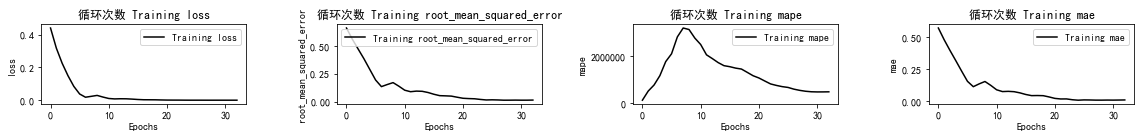

ValueError: in user code:

    C:\Users\HUAWEI\AppData\Roaming\Python\Python36\site-packages\keras\engine\training.py:1586 predict_function  *
        return step_function(self, iterator)
    C:\Users\HUAWEI\AppData\Roaming\Python\Python36\site-packages\keras\engine\training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\HUAWEI\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\HUAWEI\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\HUAWEI\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\HUAWEI\AppData\Roaming\Python\Python36\site-packages\keras\engine\training.py:1569 run_step  **
        outputs = model.predict_step(data)
    C:\Users\HUAWEI\AppData\Roaming\Python\Python36\site-packages\keras\engine\training.py:1537 predict_step
        return self(x, training=False)
    C:\Users\HUAWEI\AppData\Roaming\Python\Python36\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\HUAWEI\AppData\Roaming\Python\Python36\site-packages\keras\engine\input_spec.py:218 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 64)


In [104]:
mode='LSTM' 
set_my_seed()
train_fuc(mode=mode,window_size=window_size,batch_size=batch_size,epochs=epochs,hidden_dim=hidden_dim)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled = scaler.fit_transform(df_for_testing)
df_for_training_scaled[1]

array([[-1.72177148,  0.39968477, -0.28679889,  1.33915253],
       [-1.70115147,  0.62927986, -0.06876642,  1.46712657],
       [-1.68053145,  0.82593311, -0.18622368,  1.46993546],
       [-1.65991143,  0.82376875, -0.36872002,  1.47321027],
       [-1.63929141,  0.78322648, -0.55769281,  1.46998871],
       [-1.61867139,  0.75231784, -0.48378316,  1.47118015],
       [-1.59805138,  0.74282674, -0.41785706,  1.47092389],
       [-1.57743136,  1.14456278, -0.51760631,  1.47888129],
       [-1.55681134,  1.10785623, -0.60932259,  1.47295068],
       [-1.53619132,  1.05484   , -0.70820023,  1.47492423],
       [-1.51557131,  0.99619855, -0.8788879 ,  1.47575957],
       [-1.49495129,  1.31698373, -0.58375527,  1.41470957],
       [-1.47433127,  1.26558002, -0.64917032,  1.41663652],
       [-1.45371125,  1.19234073, -0.87889248,  1.35256796],
       [-1.43309123,  1.40854634, -1.04004974,  1.35257129],
       [-1.41247122,  1.3688687 , -1.20043135,  1.34757919],
       [-1.3918512 ,  1.

定义随机种子和评估函数

In [32]:
def set_my_seed():
    os.environ['PYTHONHASHSEED'] = '0'##主要是为了禁止hash随机化，使得实验可复现。
    np.random.seed(1)##Numpy 在一个明确的初始状态生成固定随机数字所必需的。
    rn.seed(12345)##Python 在一个明确的初始状态生成固定随机数字所必需的。
    tf.random.set_seed(123)##在一个明确的初始状态下生成固定随机数字。
    
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = np.sqrt(mean_squared_error(y_test, y_predict))
    mape=(abs(y_predict -y_test)/ y_test).mean()
    r_2=r2_score(y_test, y_predict)
    return mae, rmse, mape,r_2  #mse

构建序列数据的测试集和数据集

In [33]:
def build_sequences(text, window_size=24):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+window_size]
        x.append(sequence)
        y.append(target)
    return np.array(x), np.array(y)


In [34]:
def get_traintest(data,train_size=len(data0),window_size=24):
    train=data[:train_size]
    test=data[train_size-window_size:]
    X_train,y_train=build_sequences(train,window_size=window_size)
    X_test,y_test=build_sequences(test,window_size=window_size)
    return X_train,y_train[:,-1],X_test,y_test[:,-1]


NameError: name 'data0' is not defined